In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [3]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})

In [4]:
VC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
MC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_sst.nc",  use_cftime=True, chunks= {"time":240})
OC = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_sst.nc",  use_cftime=True, chunks= {"time":240})

In [5]:
ctrl = ctrl_sst.sst.compute()

In [6]:
OC = OC.sst.compute()

In [7]:
MC = MC.sst.compute()

In [8]:
VC = VC.sst.compute()

In [9]:
def roll_longitude(df):
    """
    Rolls the longitude coordinates of a given DataFrame to a range of [0, 360).

    Parameters:
    df (xarray.DataArray): Input DataFrame containing longitude coordinates.

    Returns:
    xarray.DataArray: DataFrame with rolled longitude coordinates.
    """
    # Ensure the longitude coordinates are within the range [0, 360)
    df.coords['xt_ocean'] = (df.coords['xt_ocean']) % 360
    
    # Sort the DataFrame based on the rolled longitude coordinates
    df = df.sortby(df.xt_ocean)
    
    return df

In [10]:
ctrl = roll_longitude(ctrl)
MC = roll_longitude(MC)
VC = roll_longitude(VC)
OC = roll_longitude(OC)

In [11]:
ctrl = ctrl.sel(time = slice("0952-01-01", "1150-12-31"))
MC = MC.sel(time = slice("0952-01-01", "1100-12-31"))
OC = OC.sel(time = slice("0952-01-01", "1020-12-31"))
VC = VC.sel(time = slice("0952-01-01", "1020-12-31"))

In [12]:
len(OC)/12

69.0

In [13]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def dmi(DS):
    WTIO = ssta(DS).sel(yt_ocean=slice(-10, 10),xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO = ssta(DS).sel(yt_ocean=slice(-10, 0),xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return  WTIO-SETIO

In [14]:
def percentiles_index(index, da1):
    #Step 0 get the index of the control. 
    da = index(ctrl)
    # Step 1: Number of iterations
    num_iterations = 1000
    # Step 2 and 3: Loop over the iterations
    std_deviations = []
    for _ in range(num_iterations):
        # Step 2: Randomly select years base don lenght of TS with replacement
        length = int(len(da1)/12)
        random_years = np.random.choice(da['time.year'], size=length, replace=True)

        # Step 3: Calculate the standard deviation for the selected 30 years
        selected_years_data = da.sel(time=np.isin(da['time.year'], random_years))
        std_dev = selected_years_data.groupby('time.month').std(dim='time')

        # Step 4: Store the standard deviation value
        std_deviations.append(std_dev)

    # Step 5: Calculate the 5th and 95th percentiles
    std_deviations = xr.concat(std_deviations, dim='iterations')
    percentiles = std_deviations.quantile([0.05, 0.95], dim = 'iterations')
    return percentiles-da.groupby("time.month").std("time")

In [15]:
OC_p = percentiles_index(dmi, OC)
MC_p = percentiles_index(dmi, MC)
VC_p = percentiles_index(dmi, VC)

In [16]:
OC_p

<xarray.DataArray 'sst' (quantile: 2, month: 12)>
array([[-0.06482092, -0.04408736, -0.03783205, -0.02805343, -0.02529442,
        -0.05112952, -0.0527456 , -0.07388946, -0.08760559, -0.08065343,
        -0.07004092, -0.07294925],
       [ 0.05343348,  0.03329761,  0.03257914,  0.02361316,  0.02323837,
         0.04305431,  0.0436446 ,  0.06413126,  0.07627922,  0.06787505,
         0.05762808,  0.05434543]])
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantile  (quantile) float64 0.05 0.95

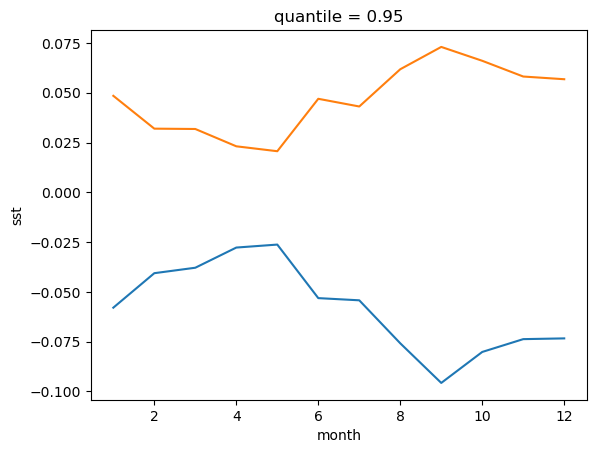

In [17]:
(VC_p)[0].plot()
(VC_p)[1].plot()

In [18]:
OC_dmi = dmi(OC).groupby("time.month").std("time")
MC_dmi = dmi(MC).groupby("time.month").std("time")
VC_dmi = dmi(VC).groupby("time.month").std("time")
ctrl_dmi = dmi(ctrl).groupby("time.month").std("time")

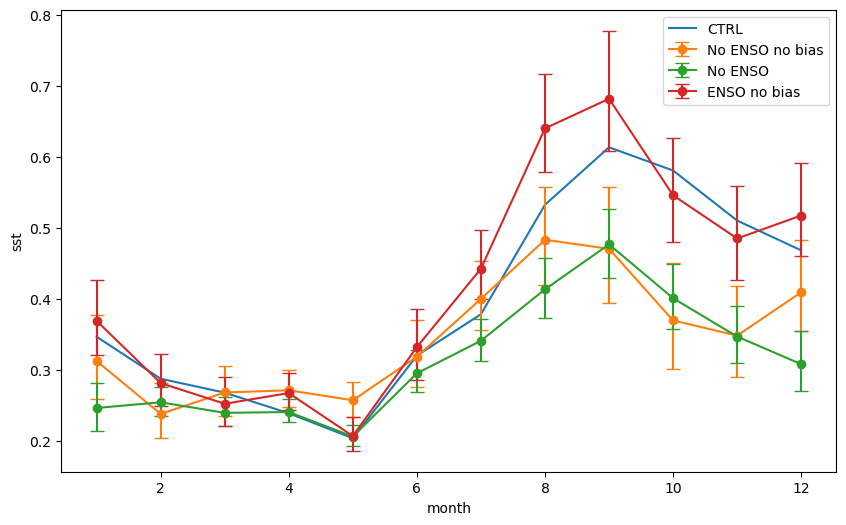

In [19]:
plt.figure(figsize = (10,6))
ctrl_dmi.plot(label = "CTRL")
plt.errorbar(OC_dmi.month, OC_dmi, yerr=[abs(OC_p[1]), abs(OC_p[0])]
                 , fmt='-o', capsize=5, label = 'No ENSO no bias')
plt.errorbar(MC_dmi.month, MC_dmi, yerr=[abs(MC_p[1]), abs(MC_p[0])]
                 , fmt='-o', capsize=5, label = 'No ENSO')
plt.errorbar(VC_dmi.month, VC_dmi, yerr=[abs(VC_p[1]), abs(VC_p[0])]
                 , fmt='-o', capsize=5, label = 'ENSO no bias')
plt.legend()

In [20]:
obs = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_Climatology2.nc", decode_times=False)

In [21]:
obs = obs.temp[0]

In [22]:
obs = obs.drop("DEPTH1_1")

In [23]:
obs = obs.rename({"TIME":"month", "GRID_Y_T":"yt_ocean", "GRID_X_T":"xt_ocean"})

In [24]:
obs["month"] = [1,2,3,4,5,6,7,8,9,10,11,12]

In [25]:
obs = roll_longitude(obs)

In [26]:
def plot_bias_sig_annual(ctrl, exp, temp_scale=2):
    ctrl_mn = ctrl.sel(month = slice(9,11)).mean('month')
    exp_mn = exp.groupby("time.season")["SON"].mean("time")
    # Now plot figure
    plt.figure(figsize=(12, 4))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

    # Set extent for longitude and latitude if provided
    ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())

    bias = (exp_mn - ctrl_mn)
    bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='temp bias oC'))

    ax.coastlines(color='k')
    ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
    ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
    ax.gridlines()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
   
    # Plot significance
    #ax.contourf(sig_p.longitude, sig_p.latitude, sig_p, levels=[0, 0.05],
    #            hatches=['///'], alpha=0.0, add_colorbar=False, transform=ccrs.PlateCarree())
    
    return


In [34]:
exp_title = {"CTRL":"a) CTRL" , "ENSO no bias": "b) ENSO no bias", "No ENSO":"c) no ENSO", "No ENSO no bias":"d) No ENSO no bias"}

In [64]:
from scipy.stats  import ttest_ind, ttest_1samp

In [62]:
ctrl.groupby("time.season")["SON"].groupby("time.year").mean("time")

<xarray.DataArray 'sst' (year: 199, yt_ocean: 300, xt_ocean: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.6659794, -1.665978 , -1.6654695, ..., -1.6699516,
         -1.667729 , -1.6663357],
        [-1.6696831, -1.6695662, -1.6687294, ..., -1.6729665,
         -1.6717167, -1.6704537],
        [-1.6756153, -1.6745286, -1.6729034, ..., -1.6789227,
         -1.6779695, -1.6768417]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.7131227, -1.7219248, -1.7305759, ..., -1.6913878,
         -1.697554 , -1.7049724],
        [-1.700776 , -1.7086827, -1.7169018, ..., -1.6800776,
         -1.6858349, -1.6929135],
        [-1.6870513, -1.6941141, -1.7018663, ..., -1.6691545,
         -1.6739463, -1.6800574]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.6804193, -1.6841561, -1.6891369, ..., -1.6750447,
         -1.6763998, -1.6781373],
        [-1.6765175, -1.6795998, -1.6839179, ..., -1.672911 ,
         -1.6736269, -1.6745601],
        [-1.67409  , -1.6768956, -1.6803755, ..., -1.6724639,
         -1.6724596, -1.6726408]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
    geolat_t  (yt_ocean, xt_ocean) float32 -77.88 -77.88 -77.88 ... 88.1 87.88
    geolon_t  (yt_ocean, xt_ocean) float32 0.5 1.5 2.5 3.5 ... 72.32 73.23 73.94
  * year      (year) int64 952 953 954 955 956 957 ... 1146 1147 1148 1149 1150
Attributes:
    long_name:      Potential temperature
    units:          degrees K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [65]:
def plot_bias_sig_annual(ctrl, exp_list, temp_scale=2):
    ctrl_mn = ctrl.sel(month=slice(9, 11)).mean('month')
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])  # Position for colorbar
    
    for i, name in enumerate(exp_list.keys()):
        print(str(name))
        exp = exp_list[name]
        exp_mn = exp.groupby("time.season")["SON"].mean("time")
        bias = (exp_mn - ctrl_mn)
        #calc significance of SON mean in each yera versus SON mena of obs
        #CTRL = exp_list["CTRL"]
        dims = ('yt_ocean', 'xt_ocean')
        t_stat, p_value = ttest_1samp(exp.groupby("time.season")["SON"].groupby("time.year").mean("time"), ctrl_mn)
        t_stat_ds = xr.DataArray(t_stat, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
        p_value_ds = xr.DataArray(p_value, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
        sig_p = p_value_ds.where(p_value_ds < 0.05, np.nan)
        
        ax = axs.flat[i]
        ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())
        im = bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                                transform=ccrs.PlateCarree(), add_colorbar=False)
        
        ax.contourf(sig_p.xt_ocean, sig_p.yt_ocean, sig_p, levels=[0, 0.05],
                hatches=['///'], alpha=0.0, add_colorbar=False, transform=ccrs.PlateCarree())
        
        ax.set_title(exp_title[name], loc='left')
        ax.coastlines(color='k')
        ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
        ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
        ax.gridlines()
    
    fig.colorbar(im, cax=cbar_ax, label='temperature bias $^\circ$C')
    
    for ax in axs.flat:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
    
    plt.tight_layout()
    plt.show()

In [66]:
exps1 = {"CTRL":ctrl, "ENSO no bias": VC, "No ENSO":MC, "No ENSO no bias":OC}

In [67]:
exp_title = {"CTRL":"a) CTRL" , "ENSO no bias": "b) ENSO no bias", "No ENSO":"c) no ENSO", "No ENSO no bias":"d) No ENSO no bias"}

CTRL


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


ENSO no bias


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


No ENSO


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)


No ENSO no bias


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/jobfs/114017902.gadi-pbs/ipykernel_3199939/2141944727.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


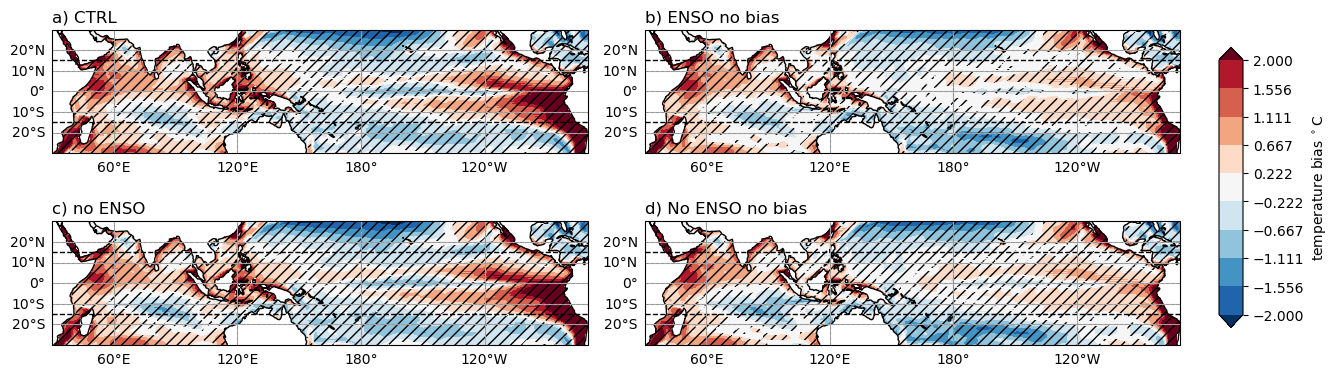

In [68]:
plot_bias_sig_annual(obs, exps1)


In [ ]:
def plot_bias_sig_annual(ctrl, exp, temp_scale=2):
    ctrl_mn = ctrl.mean('time')
    exp_mn = exp.mean("time")
    # Now calculate significance for annual component
    dims = ('latitude', 'longitude')
    t_stat, p_value = ttest_ind(exp, ctrl)
    t_stat_ds = xr.DataArray(t_stat, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    p_value_ds = xr.DataArray(p_value, dims=dims, coords={dim: exp.coords[dim] for dim in dims})
    sig_p = p_value_ds.where(p_value_ds < 0.05, np.nan)
    
    # Now plot figure
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    bias = (exp_mn - ctrl_mn)
    bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                       transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='Depth bias ($m$)'))

    ax.coastlines(color='k')
    ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
    ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
    ax.gridlines()
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
   
    # Plot significance
    ax.contourf(sig_p.longitude, sig_p.latitude, sig_p, levels=[0, 0.05],
                hatches=['///'], alpha=0.0, add_colorbar=False, transform=ccrs.PlateCarree())
    
    return



In [30]:
#PIOD-like mean state bias

In [31]:
def EIO_bias(da, obs):
    da1 = da.groupby("time.month") - obs
    E = da1.sel(xt_ocean=slice(90,110), yt_ocean=slice(-10,0)).mean(['xt_ocean', 'yt_ocean'])
    return E

In [32]:
def WIO_bias(da, obs):
    da1 = da.groupby("time.month") - obs
    W = da1.sel(xt_ocean=slice(50,70), yt_ocean=slice(-10,10)).mean(['xt_ocean', 'yt_ocean'])
    return W

In [33]:
def IOD_LIKE_bias(da, obs):
    da1 = da.groupby("time.month") - obs
    W = da1.sel(xt_ocean=slice(50,70), yt_ocean=slice(-10,10)).mean(['xt_ocean', 'yt_ocean'])
    E = da1.sel(xt_ocean=slice(90,110), yt_ocean=slice(-10,0)).mean(['xt_ocean', 'yt_ocean'])
    D = W-E
    return D

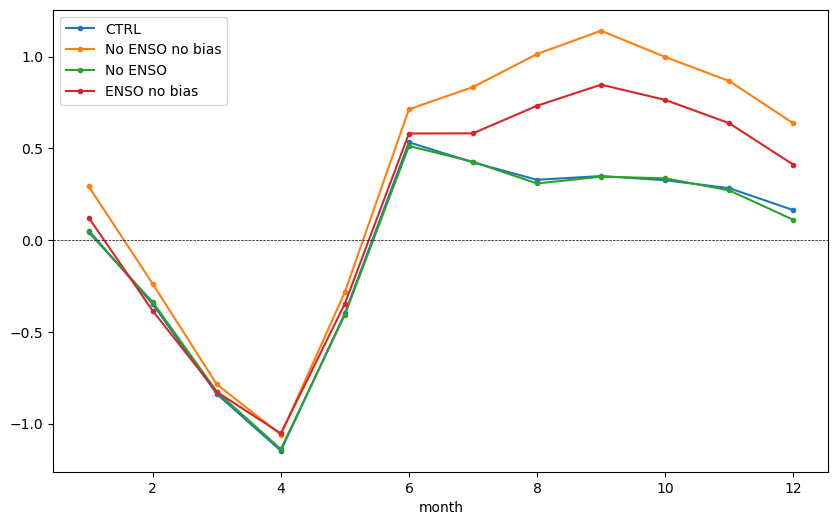

In [34]:
plt.figure(figsize = (10,6))
IOD_LIKE_bias(ctrl, obs).groupby("time.month").mean("time").plot(marker='.', label = "CTRL")
IOD_LIKE_bias(OC, obs).groupby("time.month").mean("time").plot(marker='.', label = "No ENSO no bias")
IOD_LIKE_bias(MC, obs).groupby("time.month").mean("time").plot(marker='.', label = "No ENSO")
IOD_LIKE_bias(VC, obs).groupby("time.month").mean("time").plot(marker='.', label = "ENSO no bias")
plt.axhline(0, lw = 0.5, ls = '--', color = 'k')
plt.legend()

In [35]:
from scipy.stats import ttest_ind

In [36]:
def calculate_monthly_ttest(fn, ctrl, exp, obs):
    """
    Calculate t-test statistics for each month.

    Parameters:
        EIO_bias (function): Function to calculate bias.
        ctrl (xarray.DataArray): Control data.
        MC (xarray.DataArray): Monte Carlo data.
        obs (xarray.DataArray): Observations.

    Returns:
        t_array (xarray.DataArray): DataArray of t-test statistics for each month.
        p_array (xarray.DataArray): DataArray of p-values for each month.
    """
    # Initialize lists to store t and p values
    t_values = []
    p_values = []

    # Loop over each month
    for i in range(1, 13):
        # Extract data for the current month
        C = fn(ctrl, obs).groupby("time.month")[i]
        E = fn(exp, obs).groupby("time.month")[i]

        # Perform t-test
        t_stat, p_stat = ttest_ind(C, E)

        # Append t and p values to lists
        t_values.append(t_stat)
        p_values.append(p_stat)

    # Convert lists to xarray DataArrays
    t_array = xr.DataArray(t_values, dims='month', coords={'month': range(1, 13)})
    p_array = xr.DataArray(p_values, dims='month', coords={'month': range(1, 13)})

    return t_array, p_array

In [37]:
t_e_m, p_e_m = calculate_monthly_ttest(EIO_bias, ctrl, MC, obs)
t_e_o, p_e_o = calculate_monthly_ttest(EIO_bias, ctrl, OC, obs)
t_e_v, p_e_v = calculate_monthly_ttest(EIO_bias, ctrl, VC, obs)


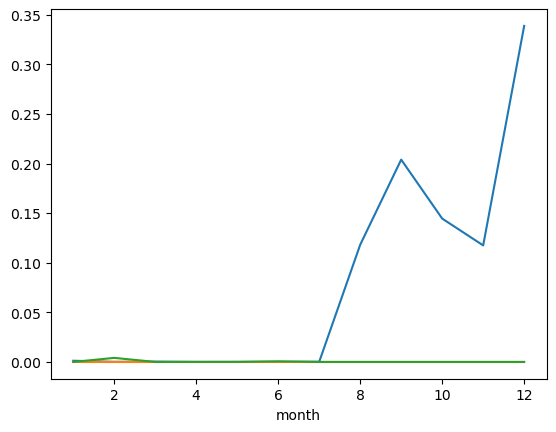

In [38]:
p_e_m.plot()
p_e_o.plot()
p_e_v.plot()

In [39]:
t_w_m, p_w_m = calculate_monthly_ttest(WIO_bias, ctrl, MC, obs)
t_w_o, p_w_o = calculate_monthly_ttest(WIO_bias, ctrl, OC, obs)
t_w_v, p_w_v = calculate_monthly_ttest(WIO_bias, ctrl, VC, obs)


In [40]:
t_d_m, p_d_m = calculate_monthly_ttest(IOD_LIKE_bias, ctrl, MC, obs)
t_d_o, p_d_o = calculate_monthly_ttest(IOD_LIKE_bias, ctrl, OC, obs)
t_d_v, p_d_v = calculate_monthly_ttest(IOD_LIKE_bias, ctrl, VC, obs)


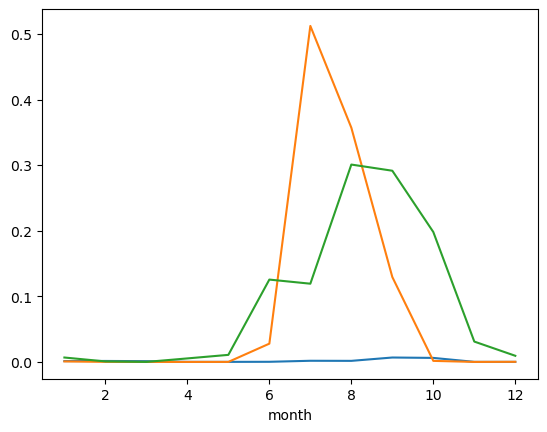

In [41]:
p_w_m.plot()
p_w_o.plot()
p_w_v.plot()

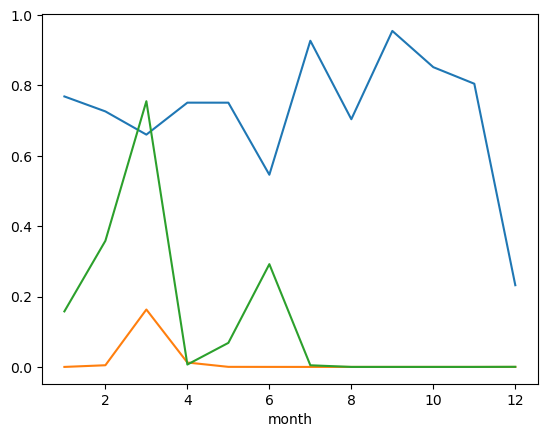

In [42]:
p_d_m.plot()
p_d_o.plot()
p_d_v.plot()

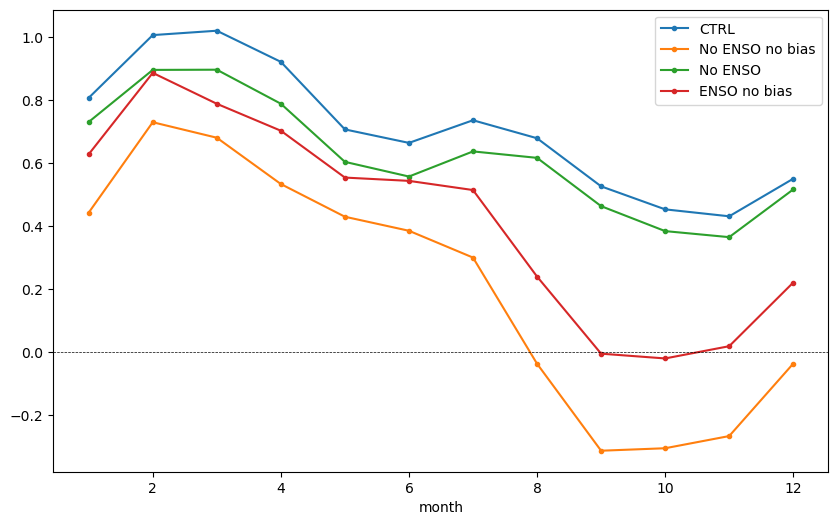

In [43]:
plt.figure(figsize = (10,6))
EIO_bias(ctrl, obs).groupby("time.month").mean("time").plot(marker='.', label = "CTRL")
EIO_bias(OC, obs).groupby("time.month").mean("time").plot(marker='.', label = "No ENSO no bias")
EIO_bias(MC, obs).groupby("time.month").mean("time").plot(marker='.', label = "No ENSO")
EIO_bias(VC, obs).groupby("time.month").mean("time").plot(marker='.', label = "ENSO no bias")
plt.axhline(0, lw = 0.5, ls = '--', color = 'k')
plt.legend()

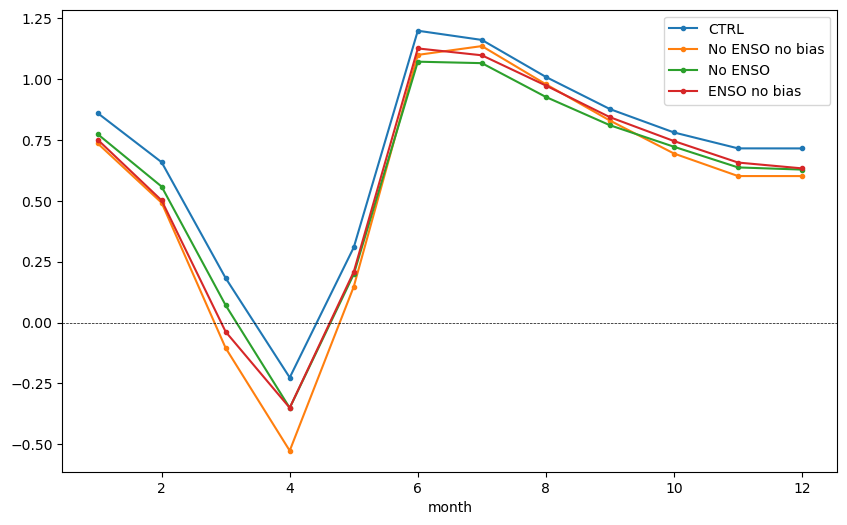

In [44]:
plt.figure(figsize = (10,6))
WIO_bias(ctrl, obs).groupby("time.month").mean("time").plot(marker='.', label = "CTRL")
WIO_bias(OC, obs).groupby("time.month").mean("time").plot(marker='.', label = "No ENSO no bias")
WIO_bias(MC, obs).groupby("time.month").mean("time").plot(marker='.', label = "No ENSO")
WIO_bias(VC, obs).groupby("time.month").mean("time").plot(marker='.', label = "ENSO no bias")
plt.axhline(0, lw = 0.5, ls = '--', color = 'k')
plt.legend()

In [45]:
print(IOD_LIKE_bias(ctrl, obs).mean("time").values)
print(IOD_LIKE_bias(OC, obs).mean("time").values)
print(IOD_LIKE_bias(MC, obs).mean("time").values)
print(IOD_LIKE_bias(VC, obs).mean("time").values)

-0.02252169595872034
0.3444339111492551
-0.029253124546519082
0.17241959200275403


In [46]:
plt.figure(figsize = (10,6))
IOD_LIKE_bias(ctrl, obs).mean("time").plot.scatter(marker='.', label = "CTRL")
IOD_LIKE_bias(OC, obs).mean("time").plot.scatter(marker='.', label = "No ENSO no bias")
IOD_LIKE_bias(MC, obs).mean("time").plot.scatter(marker='.', label = "No ENSO")
IOD_LIKE_bias(VC, obs).mean("time").plot.scatter(marker='.', label = "ENSO no bias")
plt.axhline(0, lw = 0.5, ls = '--', color = 'k')
plt.legend()

TypeError: No numeric data to plot.

<Figure size 1000x600 with 0 Axes>

In [35]:
#calculate the SST bias int he DMI boxes to create "mean state DMI bias plot"
test = ctrl.groupby("time.month") - obs

In [39]:
W = test.sel(xt_ocean=slice(50,70), yt_ocean=slice(-10,10)).mean(['xt_ocean', 'yt_ocean'])

In [44]:
E = test.sel(xt_ocean=slice(90,110), yt_ocean=slice(-10,0)).mean(['xt_ocean', 'yt_ocean'])

In [45]:
D = W-E

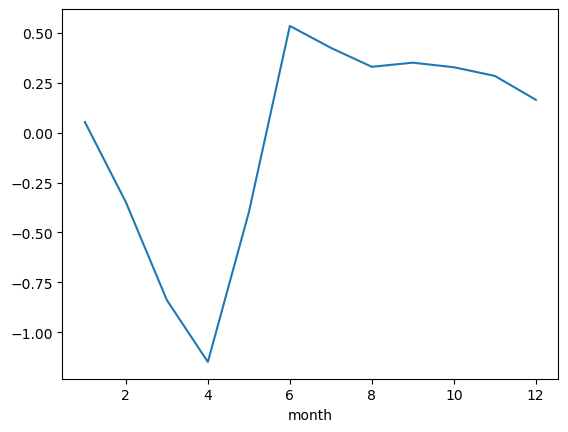

In [46]:
D.groupby("time.month").mean("time").plot()

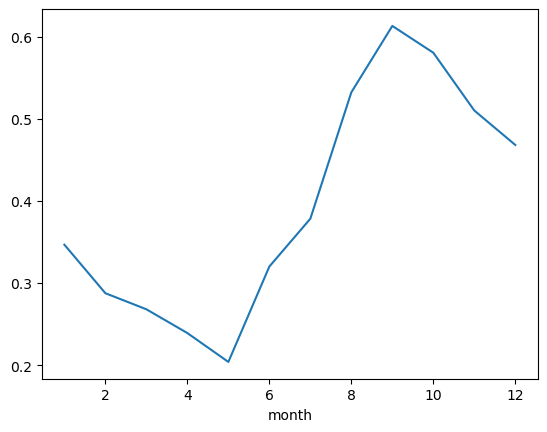

In [47]:
D.groupby("time.month").std("time").plot()

In [42]:
W2 = test.groupby("time.month").mean("time").sel(xt_ocean=slice(50,70), yt_ocean=slice(-10,10)).mean(['xt_ocean', 'yt_ocean'])

In [65]:
def plot_std_dev_SON(ctrl, exp_list, temp_scale=1):
    ctrl_mn = ctrl.groupby("time.season")["SON"].std("time")
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    #cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])  # Position for colorbar
    
    for i, name in enumerate(exp_list.keys()):
        print(str(name))
        exp = exp_list[name]
        exp_mn = exp.groupby("time.season")["SON"].std("time")
        if i == 0:
            bias = ctrl_mn
            ax = axs.flat[i]
            ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())
            im = bias.plot.contourf(ax=ax,  cmap="jet", vmax = 3, levels=10, extend='neither',
                                    transform=ccrs.PlateCarree(), add_colorbar=True)
            #ax.set_title(name+"-HadISST observations SON")
            ax.coastlines(color='k')
            ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
            ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
            ax.gridlines()
        else:
            bias = (exp_mn - ctrl_mn)
            ax = axs.flat[i]
            ax.set_extent([30, 290, -30, 30], crs=ccrs.PlateCarree())
            im = bias.plot.contourf(ax=ax, vmin=-1*temp_scale, vmax=temp_scale, cmap="RdBu_r", levels=10, extend='both',
                                    transform=ccrs.PlateCarree(), add_colorbar=True)
            #ax.set_title(name+"-HadISST observations SON")
            ax.coastlines(color='k')
            ax.axhline(y=-15, color='black', linestyle='--', linewidth=1)  # 15S
            ax.axhline(y=15, color='black', linestyle='--', linewidth=1)
            ax.gridlines()

    
    for ax in axs.flat:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
    
    plt.tight_layout()
    plt.show()

CTRL
ENSO no bias
No ENSO
No ENSO no bias


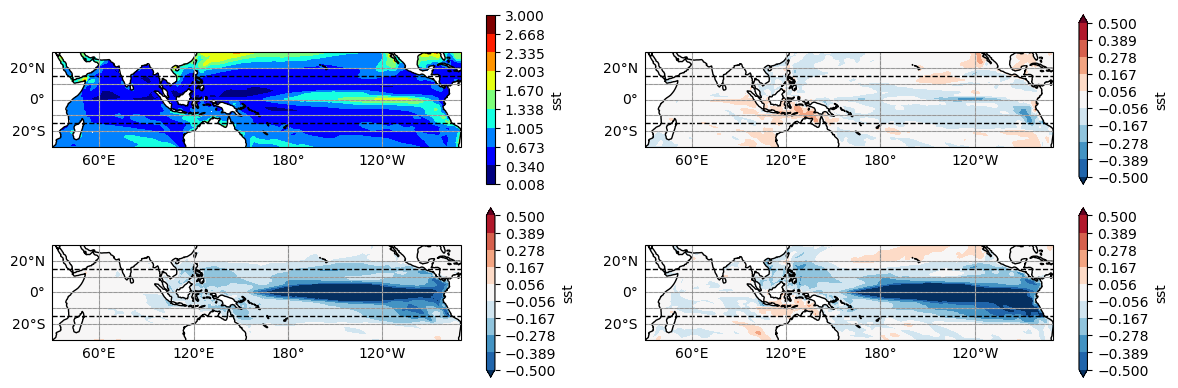

In [67]:
plot_std_dev_SON(ctrl, exps1, 0.5)

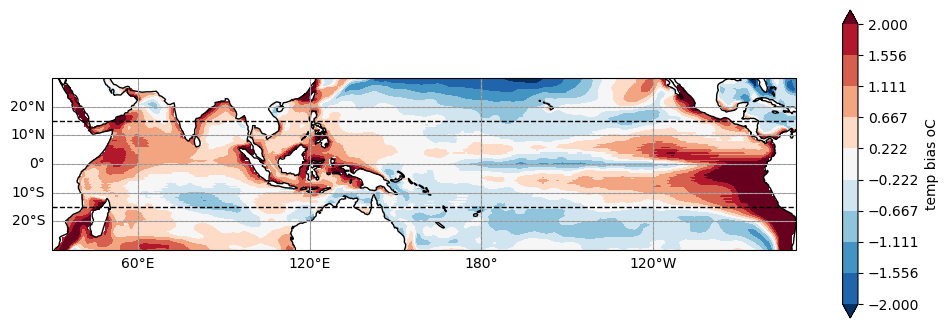

In [100]:
plot_bias_sig_annual(obs, ctrl)

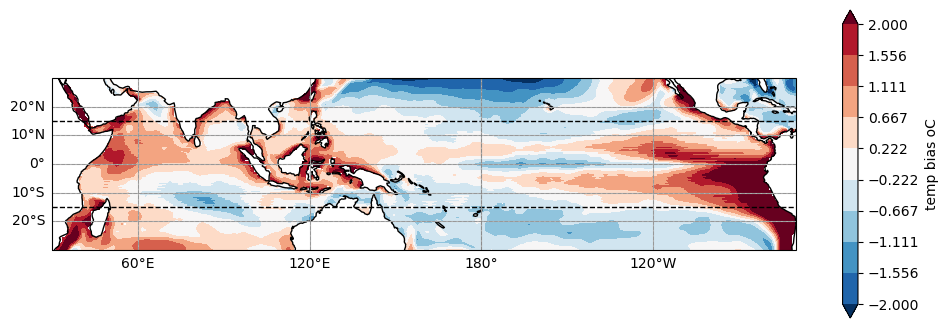

In [101]:
plot_bias_sig_annual(obs, MC)

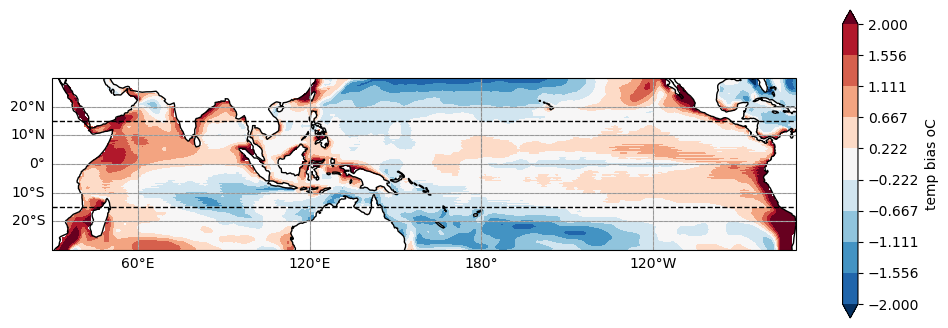

In [102]:
plot_bias_sig_annual(obs, OC)

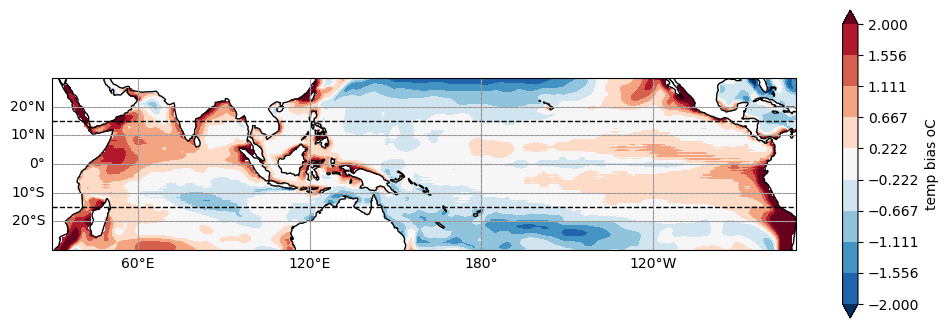

In [103]:
plot_bias_sig_annual(obs, VC)